# Script to compare methods of calculating the vertical propellant distribution

### We compare three methods:    
- Using the profile from Martin Ross's 2014 paper (https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2013EF000160)
- Obtaining the distribution from time and altitude information in online launch videos (note this relies on constant fuel burn rate)
- Combining Ross's distribution with meco/sei altitudes averaged over similar rockets.
                            

In [1]:
# Import modules
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from ipywidgets import interact
from datetime import datetime

In [2]:
# Set everything up.
str_list,start_list, mid_list,start_list_gc,mid_list_gc = [],[],[],[],[]

for i in range(0,90,5):
    str_list.append(f"{i}-{i+5}")
    start_list.append(i)
    mid_list.append(i+2.5)
    if i < 80:
        start_list_gc.append(i)
        mid_list_gc.append(i+2.5)
for i in range(90,650,10):
    str_list.append(f"{i}-{i+10}") 
    start_list.append(i)
    mid_list.append(i+5)
    
eloise_prop_burn = [25.10310991, 8.89068476, 6.798758934, 5.752796021, 5.229814565, 4.706833108, 4.183851652,
                   3.660870195, 3.660870195, 3.137888739, 3.137888739, 2.614907282, 2.091925826, 0, 0.114292392,
                   0.342877175, 0.342877175, 0.400023371, 0.742900546, 0.914339134, 0.914339134, 1.142923917,
                   1.371508701, 1.885824463]
ross_alt = np.arange(102.5, 0, -5)
ross_prop_mass = np.asarray([21.0, 2.0, 2.1, 2.3, 2.4, 2.6, 2.7, 2.9, 3.5, 4.0, 3.2, 2.3, 2.5, 2.7, 3.0, 3.3, 3.9, 4.4, 5.0, 6.9, 17.3])
ross_prop_mass = ross_prop_mass / np.sum(ross_prop_mass) * 100
ross_cumulative_mass = np.zeros_like(ross_prop_mass)
for i in range(0,len(ross_prop_mass)):
    if i == 0:
        ross_cumulative_mass[i] = 100
    else:
        ross_cumulative_mass[i] = ross_cumulative_mass[i-1] - ross_prop_mass[i-1]

In [3]:
# Here we try to replicate the process that is used in the main script.
# In the same way as in the main script, arrays of gc_relative_mass_stage1/2 determine the percentage of stage propellant burned in each bin.
# Note that in the main program the bins are defined by the box heights over 47 layers, here it is different.

# The average altitudes for 2S rockets.
#meco_lev  = 73
#sei_lev   = 92        

def main_script_method(vehicle,array_len,filename_array,alt_meco,alt_sei,prop_s1,prop_s2,total_prop,alt_beco,prop_b):
    combo_dis_array = np.zeros((len(str_list),array_len)) 
    for count in range(array_len):
        
        meco_lev = alt_meco[count]
        sei_lev  = alt_sei[count]
        gc_top = 80
        
        h = gc_top
        propellant_in_gc = np.interp(h, ross_alt[::-1], ross_cumulative_mass[::-1])
        gc_relative_mass = np.zeros(len(start_list_gc))
        for l, h in enumerate(mid_list_gc):
            gc_relative_mass[l] = np.clip(np.interp(h,ross_alt[::-1], ross_prop_mass[::-1]),None,17.3)
        gc_relative_mass = propellant_in_gc * gc_relative_mass / np.sum(gc_relative_mass)

        # Booster:
        if vehicle == "Boosters":
            beco_lev = alt_beco[count]
            if beco_lev > gc_top:
                gc_relative_mass_booster = np.asarray(gc_relative_mass)
                if beco_lev < 102.5:
                    beco_mass = np.interp(beco_lev,ross_alt[::-1], ross_cumulative_mass[::-1])
                    gc_percent = propellant_in_gc / beco_mass * 100
                    gc_relative_mass_booster = gc_relative_mass_booster / np.sum(gc_relative_mass_booster) * gc_percent
                else:
                    gc_relative_mass_booster = gc_relative_mass_booster / np.sum(gc_relative_mass_booster) * propellant_in_gc   
            else:
                BECO_alt_index = np.argmin(np.abs(beco_lev - np.asarray(mid_list_gc)))
                gc_relative_mass_booster = np.asarray(gc_relative_mass[:BECO_alt_index+1])
                gc_relative_mass_booster = gc_relative_mass_booster / np.sum(gc_relative_mass_booster) * 100
            combo_dis_array[:len(gc_relative_mass_booster),count] += (gc_relative_mass_booster * prop_b[count] / total_prop[count])  
        
        # Stage 1:
        if meco_lev > gc_top:
            gc_relative_mass_stage1 = np.asarray(gc_relative_mass)
            if meco_lev < 102.5:
                meco_mass = np.interp(meco_lev,ross_alt[::-1], ross_cumulative_mass[::-1])
                gc_percent = propellant_in_gc / meco_mass * 100
                gc_relative_mass_stage1 = gc_relative_mass_stage1 / np.sum(gc_relative_mass_stage1) * gc_percent
            else:
                gc_relative_mass_stage1 = gc_relative_mass_stage1 / np.sum(gc_relative_mass_stage1) * propellant_in_gc   
        else:
            MECO_alt_index = np.argmin(np.abs(meco_lev - np.asarray(mid_list_gc)))
            gc_relative_mass_stage1 = np.asarray(gc_relative_mass[:MECO_alt_index+1])
            gc_relative_mass_stage1 = gc_relative_mass_stage1 / np.sum(gc_relative_mass_stage1) * 100
            
        if vehicle == "falcon":
            gc_relative_mass_stage1 = gc_relative_mass_stage1 / 100 * (100-5.6-1.2)

        # Stage 2:                
        if sei_lev > gc_top:
            gc_relative_mass_stage2 = np.asarray([0])
            SEI_alt_index = len(mid_list_gc)
        else:   
            # Find out where SEI occurs and select the relevant subarray from self.gc_relative_mass.   
            SEI_alt_index = np.argmin(np.abs(sei_lev - np.asarray(mid_list_gc)))
            gc_relative_mass_stage2 = np.asarray(gc_relative_mass[:len(mid_list_gc)-SEI_alt_index])

            # Now interpolate the cumulative mass to optimise what percentage of propellant is within GEOS-Chem.
            sei_mass = np.interp(sei_lev,ross_alt[::-1], ross_cumulative_mass[::-1])
            gc_percent = (propellant_in_gc - sei_mass) / (100 - sei_mass) * 100
            gc_relative_mass_stage2 = gc_relative_mass_stage2 / np.sum(gc_relative_mass_stage2) * gc_percent
        
         
        combo_dis_array[:len(gc_relative_mass_stage1),count] += (gc_relative_mass_stage1 * prop_s1[count] / total_prop[count])
        combo_dis_array[SEI_alt_index:SEI_alt_index+len(gc_relative_mass_stage2),count] += (gc_relative_mass_stage2 * prop_s2[count] / total_prop[count])
        
    return combo_dis_array

In [4]:
# This method depends on whether the rocket thrust can be throttled.
# For example, Falcon 9 1st stage has the multiple burns and is likely not burning at a constant rate. Stage 2 will be OK. Space Shuttle will not be useful.

def video_analysis_method(vehicle,array_len,filename_array,sorted_files,alt_meco,alt_sei,alt_seco,prop_s1,prop_s2,t_meco,t_sei_seco,t_beco,alt_beco,prop_b,total_prop):
    prop_burned_total = np.zeros((len(str_list),array_len)) 
    launch_pairs = []
    for count in range(array_len):
        print(filename_array[count])
        
        burnrate_s1 = prop_s1[count]/t_meco[count]
        burnrate_s2 = prop_s2[count]/t_sei_seco[count]

        time, time_bins_b, time_bins_s1, time_bins_s2 = [], [], [], []
        time_elapsed_b, time_elapsed_s1, time_elapsed_s2 = [], [], []
        alt = []

        # Opening JSON file
        failed_falcon_list = ["30_05_2020","06_10_2020","25_11_2020"]
        failed_electron_list = ["31_08_2020","28_10_2020","20_11_2020","15_12_2020"]
        if vehicle == "falcon" and filename_array[count] in failed_falcon_list:
            data = np.genfromtxt("InputFiles\spacex_failedvids.csv",delimiter=",",skip_header=2,dtype=int)
            time = data[:,failed_falcon_list.index(filename_array[count])+1]
            alt  = data[:,0]
        elif vehicle == "electron" and filename_array[count] in failed_electron_list:
            data = np.genfromtxt("InputFiles\electron_failedvids.csv",delimiter=",",skip_header=2,dtype=int)
            time = data[:,failed_electron_list.index(filename_array[count])+1]
            alt  = data[:,0]
        elif vehicle == "other_no_booster":
            data = np.genfromtxt("InputFiles\other_data.csv",delimiter=",",skip_header=2,dtype=int)
            time = data[:,1]
            alt  = data[:,0]
        elif vehicle == "Boosters":
            data = np.genfromtxt("InputFiles\\booster_data.csv",delimiter=",",skip_header=2,dtype=int)
            time = data[:,1]
            alt  = data[:,0]
        else: 
            with open(sorted_files[count], 'r') as file:
                for line in file:
                    time.append(json.loads(line)["time"])
                    alt.append(json.loads(line)["altitude"])
                    
        if alt_meco[count] < 90:
            alt_bins_s1 = np.arange(0,alt_meco[count],5)
            alt_bins_s1 = np.append(alt_bins_s1,alt_meco[count])
        else:
            alt_bins_s1 = np.arange(0,90,5)
            q,mod = divmod(alt_meco[count],10)
            alt_bins_s1 = np.concatenate((alt_bins_s1,np.arange(90,alt_meco[count],10),[10*(q+1)]))
        for i in range(len(alt_bins_s1)):
            idx = (np.abs(alt - alt_bins_s1[i])).argmin()
            time_bins_s1.append(time[idx])
        for i in range(1,len(alt_bins_s1)):
            time_elapsed_s1.append(time_bins_s1[i]-time_bins_s1[i-1])
        prop_burned_s1 = np.array(time_elapsed_s1) * burnrate_s1 / total_prop[count] * 100
        prop_burned_total[:len(prop_burned_s1),count] += prop_burned_s1
                                   
        if vehicle == "Boosters":
            burnrate_b = prop_b[count]/t_beco[count]  
            if alt_beco[count] < 90:
                alt_bins_b = np.arange(0,alt_beco[count],5)
                alt_bins_b = np.append(alt_bins_b,alt_beco[count])
            else:
                alt_bins_b = np.arange(0,90,5)
                q,mod = divmod(alt_beco[count],10)
                alt_bins_b = np.concatenate((alt_bins_b,np.arange(90,alt_beco[count],10),[10*(q+1)])) 
            for i in range(len(alt_bins_b)):
                idx = (np.abs(alt - alt_bins_b[i])).argmin()
                time_bins_b.append(time[idx])
            for i in range(1,len(alt_bins_b)):
                time_elapsed_b.append(time_bins_b[i]-time_bins_b[i-1])
            prop_burned_b = np.array(time_elapsed_b) * burnrate_b / total_prop[count] * 100
            prop_burned_total[:len(prop_burned_b),count] += prop_burned_b
        else:    
            q,mod = divmod(alt_sei[count],5)
            alt_bins_s2 = np.arange(q*5,90,5)
            q,mod = divmod(alt_seco[count],10)
            alt_bins_s2 = np.concatenate((alt_bins_s2,np.arange(90,alt_seco[count],10),[10*(q+1)]))
            for i in range(len(alt_bins_s2)):
                idx = (np.abs(alt - alt_bins_s2[i])).argmin()
                time_bins_s2.append(time[idx])
            for i in range(1,len(alt_bins_s2)):
                time_elapsed_s2.append(time_bins_s2[i]-time_bins_s2[i-1])
            start = (np.abs(start_list - alt_bins_s2[0])).argmin()
            stop = (np.abs(start_list - alt_bins_s2[-2])).argmin()    
            prop_burned_s2 = np.array(time_elapsed_s2) * burnrate_s2 / total_prop[count] * 100    
            prop_burned_total[start:stop,count] = prop_burned_s2[:-1:] 
        
        pair = [f"{filename_array[count]}",count]
        launch_pairs.append(pair)
        
    return prop_burned_total, launch_pairs

In [5]:
# Run the functions.

vehicle_list = []
for counter,vehicle in enumerate(["falcon","electron","other_no_booster","Boosters"]):
#for counter,vehicle in enumerate(["Boosters"]):
    prop_b = 0
    alt_beco, t_beco = [], []
    sorted_files = []
    print(vehicle)
    if vehicle == "falcon":
        files = glob.glob(r'Output/SpaceX_*.json')
        prop_s1 = np.full((len(files)),418700)
        prop_s2 = np.full((len(files)),111500)
        falcon_data = np.loadtxt("InputFiles\spacex_urls_2020.csv",delimiter=",",skiprows=1,usecols=(3,4,5,6,7))
        t_meco     = falcon_data[:,0]
        alt_meco   = falcon_data[:,1]
        t_sei_seco = falcon_data[:,2]
        alt_sei    = falcon_data[:,3]
        alt_seco   = falcon_data[:,4]
        sorted_files = sorted(files, key=lambda x: datetime.strptime(x, 'Output\\SpaceX_%d_%m_%Y.json'))
        array_len = len(sorted_files)
        total_prop = np.full((array_len),418700+111500)
        filename_array = np.empty((array_len),dtype=object)
        for i in range(array_len):
            filename_array[i] = sorted_files[i][-15:-5]
            
    elif vehicle == "electron":
        files = glob.glob(r'Output/RocketLab_*.json')
        prop_s1 = np.full((len(files)),9250.0)
        prop_s2 = np.full((len(files)),2050.0)	
        electron_data = np.loadtxt("InputFiles\\rocketlab_urls_2020.csv",delimiter=",",skiprows=1,usecols=(3,4,5,6,7))
        t_meco     = electron_data[:,0]
        alt_meco   = electron_data[:,1]
        t_sei_seco = electron_data[:,2]
        alt_sei    = electron_data[:,3]
        alt_seco   = electron_data[:,4]
        sorted_files = sorted(files, key=lambda x: datetime.strptime(x, 'Output\\RocketLab_%d_%m_%Y.json'))
        array_len = len(sorted_files)
        total_prop = np.full((array_len),9250+2050+245)
        filename_array = np.empty((array_len),dtype=object)
        for i in range(array_len):
            filename_array[i] = sorted_files[i][-15:-5]
            
    elif vehicle == "other_no_booster":
        other_no_booster_data = np.genfromtxt("InputFiles\other_urls_2020.csv",delimiter=",",skip_header=1,usecols=(3,4,5,6,7,8,9))
        t_meco         = [other_no_booster_data [0]]
        alt_meco       = [other_no_booster_data [1]]
        t_sei_seco     = [other_no_booster_data [2]]
        alt_sei        = [other_no_booster_data [3]]
        alt_seco       = [other_no_booster_data [4]]
        prop_s1        = [other_no_booster_data [5]]	
        prop_s2        = [other_no_booster_data [6]]	
        array_len = 1
        total_prop = [419400+157300+43062+19800]
        other_no_booster_data = np.genfromtxt("InputFiles\other_urls_2020.csv",delimiter=",",skip_header=1,usecols=(2),dtype=str) 
        filename_array = [other_no_booster_data]
        for i in range(array_len):
            filename_array[i] = str(filename_array[i])[:].replace("/","_")
            
    elif vehicle == "Boosters":
        other_booster_data = np.genfromtxt("InputFiles\\boosters_urls_2020.csv",delimiter=",",skip_header=1,usecols=(3,4,5,6,7,8,9,10,11,12,13))
        t_beco         = other_booster_data[:,0]
        alt_beco       = other_booster_data[:,1]
        t_meco         = other_booster_data[:,2]
        alt_meco       = other_booster_data[:,3]
        t_sei_seco     = other_booster_data[:,4]
        alt_sei        = other_booster_data[:,5]
        alt_seco       = other_booster_data[:,6]
        prop_b         = other_booster_data[:,7]
        prop_s1        = other_booster_data[:,8]	
        prop_s2        = other_booster_data[:,9]
        total_prop     = other_booster_data[:,10]
        array_len = np.shape((prop_s2))[0] 
        other_booster_data = np.genfromtxt("InputFiles\\boosters_urls_2020.csv",delimiter=",",skip_header=1,usecols=(2),dtype=str) 
        filename_array = other_booster_data
        for i in range(array_len):
            filename_array[i] = str(filename_array[i])[:].replace("/","_")
    
    existing_technique = main_script_method(vehicle,array_len,filename_array,alt_meco,alt_sei,prop_s1,prop_s2,total_prop,alt_beco,prop_b)
    video_analysis, launch_pairs_temp = video_analysis_method(vehicle,array_len,filename_array,sorted_files,
                                                            alt_meco,alt_sei,alt_seco,prop_s1,prop_s2,
                                                            t_meco,t_sei_seco,t_beco,alt_beco,prop_b,total_prop)
    for i in range(array_len):
        vehicle_list.append(vehicle)
    if counter == 0:
        combo_dis_array = existing_technique
        prop_burned_total = video_analysis
        launch_pairs = launch_pairs_temp
    else:
        combo_dis_array = np.concatenate((combo_dis_array,existing_technique), axis=1)
        prop_burned_total = np.concatenate((prop_burned_total,video_analysis), axis=1)
        for i in range(len(launch_pairs_temp)):
            launch_pairs_temp[i][1] += launch_pairs[-1][1] + 1
        launch_pairs.extend(launch_pairs_temp)   

falcon
07_01_2020
29_01_2020
17_02_2020
07_03_2020
18_03_2020
22_04_2020
30_05_2020
04_06_2020
13_06_2020
30_06_2020
20_07_2020
07_08_2020
18_08_2020
30_08_2020
03_09_2020
06_10_2020
24_10_2020
05_11_2020
25_11_2020
06_12_2020
13_12_2020
electron
31_01_2020
31_08_2020
28_10_2020
20_11_2020
15_12_2020
other_no_booster
30_07_2020
Boosters
16_01_2020
23_07_2020
30_07_2020
14_10_2020
02_12_2020


In [6]:
# Plot each individual launch
ross_mass_plot = np.concatenate((ross_prop_mass[:1:-1],np.zeros((len(str_list)-len(ross_prop_mass[:1:-1])))))
eloise_prop_plot = np.concatenate((eloise_prop_burn,np.zeros(len(str_list)-len(eloise_prop_burn)))) 
included = 16
num_plots = 3
def plot_layer(launch):
    df_bar = pd.DataFrame(dict(graph=str_list[:included], 
                               m=ross_mass_plot[:included],
                               n=prop_burned_total[:included,launch], 
                               o=combo_dis_array[:included,launch], 
    )) 
    ind = np.arange(len(df_bar))
    width = 1/(num_plots+1)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.barh(ind + width, df_bar.m, width, label='Ross2014')
    ax.barh(ind + width*2, df_bar.n, width, label='From Video')
    ax.barh(ind + width*3, df_bar.o, width, label='Existing Technique')
    ax.set_xlabel("Propellant Burned / %")
    ax.set_ylabel("Altitude / km")
    ax.set_xlim(0,30)
    ax.set_title(f"Vertical Propellant Distribution - {vehicle_list[launch].capitalize()} Launch {launch_pairs[launch][0]}")
    ax.legend()
    ax.set(yticks = ind + width*num_plots/2, yticklabels=df_bar.graph, ylim=[num_plots*width - 1, len(df_bar)]);

interact(plot_layer, launch=launch_pairs);

interactive(children=(Dropdown(description='launch', options=(['07_01_2020', 0], ['29_01_2020', 1], ['17_02_20…

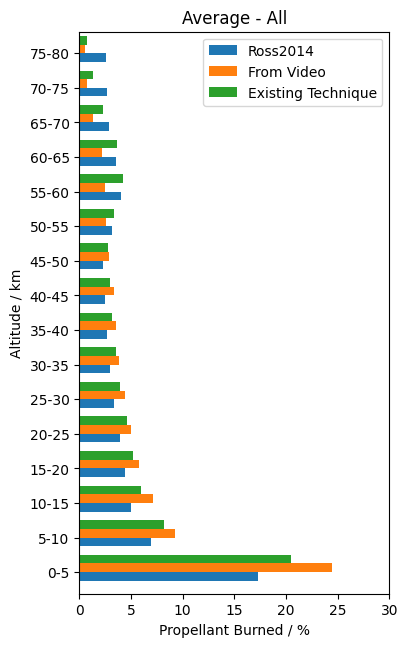

In [7]:
# Average of all plots for single rocket

combo_dis_array_average,prop_burned_average = np.zeros((len(str_list))), np.zeros((len(str_list)))  
for i in range(len(launch_pairs)):
    combo_dis_array_average[:] += combo_dis_array[:,i]
    prop_burned_average[:] += prop_burned_total[:,i]
combo_dis_array_average = combo_dis_array_average / len(launch_pairs)
prop_burned_average = prop_burned_average / len(launch_pairs)
included = 16
num_plots = 3

df_bar = pd.DataFrame(dict(graph=str_list[:included], 
                            m=ross_mass_plot[:included],
                            n=prop_burned_average[:included], 
                            o=combo_dis_array_average[:included], 
)) 
ind = np.arange(len(df_bar))
width = 1/(num_plots+1)
fig, ax = plt.subplots(figsize=(4,7.3))
ax.barh(ind + width, df_bar.m, width, label='Ross2014')
ax.barh(ind + width*2, df_bar.n, width, label='From Video')
ax.barh(ind + width*3, df_bar.o, width, label='Existing Technique')
ax.set_xlabel("Propellant Burned / %")
ax.set_ylabel("Altitude / km")
ax.set_xlim(0,30)
if counter == 3:
    ax.set_title(f"Average - All")
else:
    ax.set_title(f"Average - {vehicle.capitalize()}")
ax.legend()
ax.set(yticks = ind + width*num_plots/2, yticklabels=df_bar.graph, ylim=[num_plots*width - 1, len(df_bar)]);

Video Analysis
0-15  km: 40.84%
15-50 km: 28.73%
50-80 km: 9.71% 
---------------------
Existing Technique
0-15  km: 34.58%
15-50 km: 26.22%
50-80 km: 15.58% 
---------------------
Ross et al. 2014
0-15  km: 29.20%
15-50 km: 22.10%
50-80 km: 18.90% 


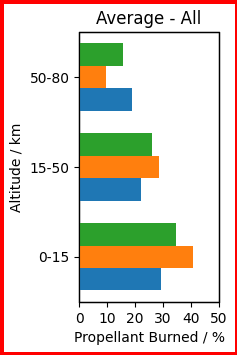

In [8]:
print("Video Analysis")
print(f"0-15  km: {np.sum(prop_burned_average[:3]):.2f}%")
print(f"15-50 km: {np.sum(prop_burned_average[3:10]):.2f}%")
print(f"50-80 km: {np.sum(prop_burned_average[10:16]):.2f}% ")
print("---------------------")
print("Existing Technique")
print(f"0-15  km: {np.sum(combo_dis_array_average[:3]):.2f}%")
print(f"15-50 km: {np.sum(combo_dis_array_average[3:10]):.2f}%")
print(f"50-80 km: {np.sum(combo_dis_array_average[10:16]):.2f}% ")
print("---------------------")
print("Ross et al. 2014")
print(f"0-15  km: {np.sum(ross_mass_plot[:3]):.2f}%")
print(f"15-50 km: {np.sum(ross_mass_plot[3:10]):.2f}%")
print(f"50-80 km: {np.sum(ross_mass_plot[10:16]):.2f}% ")

video_layer = np.zeros((3))
video_layer[0] = np.sum(prop_burned_average[:3])
video_layer[1] = np.sum(prop_burned_average[3:10])
video_layer[2] = np.sum(prop_burned_average[10:16])
existing_layer = np.zeros((3))
existing_layer[0] = np.sum(combo_dis_array_average[:3])
existing_layer[1] = np.sum(combo_dis_array_average[3:10])
existing_layer[2] = np.sum(combo_dis_array_average[10:16])
ross_layer = np.zeros((3))
ross_layer[0] = np.sum(ross_mass_plot[:3])
ross_layer[1] = np.sum(ross_mass_plot[3:10])
ross_layer[2] = np.sum(ross_mass_plot[10:16])
str_list_layer = ["0-15","15-50","50-80"]

df_bar = pd.DataFrame(dict(graph=str_list_layer, 
                            m=ross_layer,
                            n=video_layer, 
                            o=existing_layer, 
)) 
ind = np.arange(len(df_bar))
width = 1/(num_plots+1)
fig, ax = plt.subplots(figsize=(1.8,3.5), edgecolor="r",linewidth=5)
ax.barh(ind + width, df_bar.m, width, label='Ross2014')
ax.barh(ind + width*2, df_bar.n, width, label='From Video')
ax.barh(ind + width*3, df_bar.o, width, label='Existing Technique')
ax.set_xlabel("Propellant Burned / %")
ax.set_ylabel("Altitude / km")
ax.set_xlim(0,50)
ax.set_xticks(np.arange(0,60,10),labels=["0","10","20","30","40","50"])
if counter == 3:
    ax.set_title(f"Average - All")
else:
    ax.set_title(f"Average - {vehicle.capitalize()}")
#ax.legend()
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth(1)  
ax.set(yticks = ind + width*num_plots-0.25, yticklabels=df_bar.graph, ylim=[num_plots*width-0.75, len(df_bar)]);

